In [11]:
pip install pyEDM

In [12]:
import pyEDM
import matplotlib.pyplot as plt

In [13]:
ls

 5.31-3.31.xlsx
 5.31-now_date.xlsx
 Bert.ipynb
 Bert_transformers.ipynb
'CCM-data(GDELT&GDELT).xlsx'
'CCM-data_pandemic of the unvaccinated.xlsx'
 CCM-data.xlsx
 elmo.ipynb
 ERNIE.ipynb
 fastText.ipynb
'Geographicaldescroptors & Greek labels.xlsx'
 Glove.ipynb
'Google trends_GDELT_data.xlsx'
 GPT2.ipynb
'pandemic of the unvaccinated.xlsx'
 Seaborn.ipynb
 Simplex_predict-data1.xlsx
 Simplex_predict-data2.xlsx
 Word2vec.ipynb
 Wordnet2.ipynb


In [ ]:
cd drive/MyDrive/cy

/content/drive/MyDrive/cy


### Geographical descroptors(GDELT) -- Greek labels(GDELT)

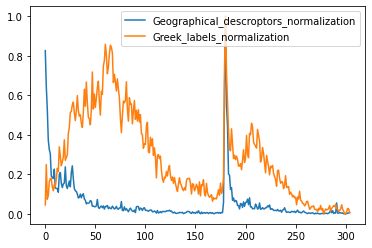

In [14]:
import pandas as pd
xlsx_file = "./5.31-3.31.xlsx"
MyData = pd.read_excel(xlsx_file, sheet_name="All", usecols=[0, 3, 4])
MyData[['Geographical_descroptors_normalization','Greek_labels_normalization']].plot();

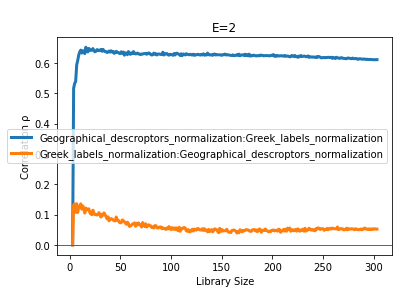

     LibSize  \
0        3.0   
1        4.0   
2        5.0   
3        6.0   
4        7.0   
..       ...   
296    299.0   
297    300.0   
298    301.0   
299    302.0   
300    303.0   

     Geographical_descroptors_normalization:Greek_labels_normalization  \
0                                             0.000000                   
1                                             0.516267                   
2                                             0.532064                   
3                                             0.538462                   
4                                             0.592666                   
..                                                 ...                   
296                                           0.610415                   
297                                           0.610388                   
298                                           0.610293                   
299                                           0.610321             

In [54]:
MyData = pd.read_excel(xlsx_file, sheet_name="All", usecols=[0, 3, 4])
myDataFrame=pyEDM.CCM(dataFrame = MyData, E=2, columns="Geographical_descroptors_normalization"
      , target="Greek_labels_normalization",libSizes = "3 303 1",showPlot=True, sample=100);
print(myDataFrame)
outputpath='./CCM-data(GDELT&GDELT).xlsx'
myDataFrame.to_excel(outputpath,index=True,header=True)

In [29]:
!pip install jdc # used fo defining functions for a class in separate cells
import jdc # used fo defining functions for a class in separate cells
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops

In [25]:
def shadow_manifold(X, tau, E, L):
    """
    Args
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((E-1) * tau, L)} # shadow manifold
    for t in range((E-1) * tau, L):
        x_lag = [] # lagged values
        for t2 in range(0, E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*tau])            
        M[t] = x_lag
    return M

In [27]:
# get pairwise distances between vectors in X
def get_distances(Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [45]:
def get_nearest_distances(t, t_steps, dists, E):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds] 
    # print(nearest_distances) 
    
    return nearest_timesteps, nearest_distances

In [38]:
# Computing "Causality" (Correlation between True and Predictions)

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: 
        
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = shadow_manifold(self.Y, self.tau, self.E, self.L) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = get_distances(self.My) # for distances between points in manifold    
        
    def causality(self):
        '''
        Args:
            None
        Returns:
            correl: how much self.X causes self.Y. correlation between predicted Y and true Y
        '''
        
        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y        
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        correl = np.corrcoef(x, y)[0][1]
        
        return correl 

    def predict(self, t):
        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = get_nearest_distances(t, self.t_steps, self.dists, E)    
        
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat
          
        # For debugging
        #     if np.isnan(X_hat):
        #         print(nearest_distances)
        #         print('u', u)
            
        return X_true, X_hat   
    def visualize_cross_mapping(self):
        # we want to check cross mapping from Mx to My and My to Mx

        f, axs = plt.subplots(1, 2, figsize=(12, 6))        
        
        for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
            #===============================================
            # Shadow Manifolds Visualization

            X_lag, Y_lag = [], []
            for t in range(1, len(self.X)):
                X_lag.append(X[t-tau])
                Y_lag.append(Y[t-tau])    
            X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

            ax.scatter(X_t, X_lag, s=5, label='$M_x$')
            ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

            #===============================================
            # Cross Mapping Visualization

            A, B = [(self.Y, self.X), (self.X, self.Y)][i]
            cm_direction = ['Mx to My', 'My to Mx'][i]

            Ma = shadow_manifold(A, tau, E, L)
            Mb = shadow_manifold(B, tau, E, L)

            t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
            t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold

            # Plot cross mapping for different time steps
            timesteps = list(Ma.keys())
            for t in np.random.choice(timesteps, size=3, replace=False):
                Ma_t = Ma[t]
                near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A, E)

                for i in range(E+1):
                    # points on Ma
                    A_t = Ma[near_t_A[i]][0]
                    A_lag = Ma[near_t_A[i]][1]
                    ax.scatter(A_t, A_lag, c='b', marker='s')

                    # corresponding points on Mb
                    B_t = Mb[near_t_A[i]][0]
                    B_lag = Mb[near_t_A[i]][1]
                    ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                    # connections
                    ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

            ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 3')
            ax.legend(prop={'size': 14})

            ax.set_xlabel('$X_t$, $Y_t$', size=15)
            ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
        plt.show()       

In [55]:
def plot_ccm_correls(X, Y, tau, E, L):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = shadow_manifold(Y, tau, E, L) # shadow manifold
    t_steps, dists = get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    coeff = np.round(np.corrcoef(X_My_true, X_My_pred)[0][1], 2)
    axs[1].scatter(X_My_true, X_My_pred, s=10, color = '#A07936')
    axs[1].set_xlabel('$GD(t)$ (observed)', size=15)
    # axs[1].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=15)
    axs[1].set_ylabel('$GL(t)$ (estimated)', size=15)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')

    # predicting Y from Mx
    coeff = np.round(np.corrcoef(Y_Mx_true, Y_Mx_pred)[0][1], 2)
    axs[0].scatter(Y_Mx_true, Y_Mx_pred, s=10, color = '#3B8791')
    axs[0].set_xlabel('$GL(t)$ (observed)', size=15)
    # axs[0].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=15)
    axs[0].set_ylabel('$GD(t)$ (estimated)', size=15)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')
    plt.show()

In [23]:
import numpy as np
X = MyData['Geographical_descroptors_normalization']
X = np.array(X).tolist()
print(X)
Y = MyData['Greek_labels_normalization']
Y = np.array(Y).tolist()
print(Y)

[0.8259867082598671, 0.6443781364437814, 0.529363895293639, 0.3728468737284688, 0.32564763325647633, 0.30503187305031876, 0.19096704190967045, 0.18499932184999318, 0.1791672317916723, 0.2266377322663773, 0.13061169130611688, 0.1296622812966228, 0.1281703512817035, 0.10972467109724672, 0.20073240200732398, 0.2095483520954835, 0.15475383154753833, 0.13318866133188662, 0.1516343415163434, 0.15638139156381392, 0.23816628238166285, 0.14227587142275874, 0.12871287128712872, 0.14783670147836703, 0.1666892716668927, 0.1371219313712193, 0.20832768208327682, 0.24332022243320225, 0.17889597178895972, 0.1280347212803472, 0.1170486911704869, 0.11365794113657941, 0.10077309100773092, 0.08029296080292962, 0.08422623084226231, 0.10023057100230573, 0.08164926081649262, 0.09616167096161672, 0.10185813101858132, 0.07595280075952801, 0.06890004068900041, 0.050725620507256215, 0.05547267055472671, 0.054523260545232606, 0.056693340566933405, 0.06713685067136851, 0.06415299064152992, 0.03906144039061441, 0.0

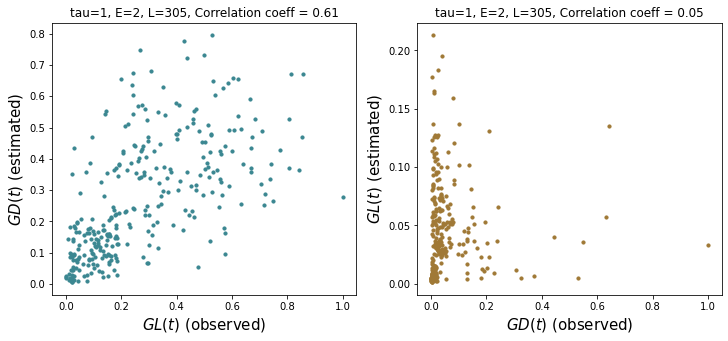

In [56]:
L = 305
tau = 1
E = 2
plot_ccm_correls(X, Y, tau, E, L)
# A title:tau=1,E=2,L=305,Correlation coeff=0.04
# B title:tau=1,E=2,L=305,Correlation coeff=0.6